In [106]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [107]:
import numpy as np
import pandas as pd

In [108]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [109]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [110]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [111]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [112]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [113]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [114]:
#Exploring the database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [115]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [116]:
import datetime as dt

In [117]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [118]:
# Perform a query to retrieve the data and precipitation scores
session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date <= '2017-08-23').\
    filter(Measurement.date >= '2016-08-01').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date <= '2017-08-23').\
    filter(Measurement.date >= '2016-08-01').all()
df = pd.DataFrame(data)
df = df.set_index('date')

In [119]:
# Sort the dataframe by date
df = df.sort_values(by=['date'])
df
# Use Pandas Plotting with Matplotlib to plot the data

,prcp
date,
2016-08-01,0.08
2016-08-01,3.53
2016-08-01,NaN
2016-08-01,2.21
2016-08-01,2.35
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


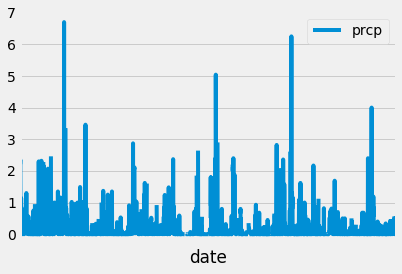

In [120]:
prcp_plot = df.reset_index().plot(x='date', y='prcp')
prcp_plot = prcp_plot.axes.get_xaxis().set_ticks([])

In [121]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2148.000000
mean,0.182896
std,0.467339
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,6.700000


In [122]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [123]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [124]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.execute("SELECT station, COUNT(*) AS 'usage' from measurement GROUP BY station ORDER BY usage DESC")
for item in active_stations:
    print(f"{item.station}: {item.usage}")

USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [126]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = session.execute("SELECT MIN(tobs) as 'MinTemp', MAX(tobs) as 'MaxTemp', AVG(tobs) as 'AvgTemp' from measurement WHERE station = 'USC00519281'")

print(f"Station USC00519281 \n")
for data in most_active:
    print(f"Minimum Temperature: {data.MinTemp}")
    print(f"Maximum Temperature: {data.MaxTemp}")
    print(f"Average Temperature: {data.AvgTemp}")

Station USC00519281 

Minimum Temperature: 54.0
Maximum Temperature: 85.0
Average Temperature: 71.66378066378067


In [129]:
temperatures = list(\
        session.query(Measurement).\
        filter(Measurement.station == 'USC00519281').\
        values(func.min(Measurement.tobs),\
           func.max(Measurement.tobs),\
           func.avg(Measurement.tobs)))
temperatures

[(54.0, 85.0, 71.66378066378067)]

In [130]:
# Choose the station with the highest number of temperature observations.
most_tempobs = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).\
    all()

most_tempobs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [131]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date2 = session.query(Measurement.date).\
               filter(Measurement.station == 'USC00519281').\
               order_by(Measurement.date.desc()).first()
latest_date2

('2017-08-18')

In [132]:
data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date <= '2017-08-18').\
    filter(Measurement.date >= '2016-08-01').all()
df = pd.DataFrame(data)
df = df.sort_values(by=['date'])
df

,date,tobs
0,2016-08-01,76.0
1,2016-08-02,76.0
2,2016-08-03,77.0
3,2016-08-04,77.0
4,2016-08-05,81.0
...,...,...
369,2017-08-14,77.0
370,2017-08-15,77.0
371,2017-08-16,76.0
372,2017-08-17,76.0


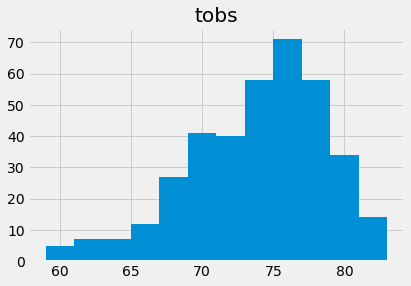

In [133]:
hist = df.hist(bins=12)

# Step 2

In [134]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [135]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2012-03-19', '2012-03-28'))

[(59.0, 69.44444444444444, 75.0)]


In [136]:
# Plot the results from your previous query as a bar chart. 
result = calc_temps('2012-03-19', '2012-03-28')
result[0]


(59.0, 69.44444444444444, 75.0)

In [137]:
#just testing variables
data = str(result[0]).strip('()')
x = data.split(", ")
print (f"Min {x[0]} - Avg {x[1]} - Max {x[2]}")

avg = float(x[1])
avg_lst = [avg]
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerror = float(x[2]) - float(x[0])

Min 59.0 - Avg 69.44444444444444 - Max 75.0


In [139]:
# Create lists for the plot
vacation_date = ['2012-03-19 to 2012-03-28']
x_pos = np.arange(len(avg_lst))
error = [yerror]

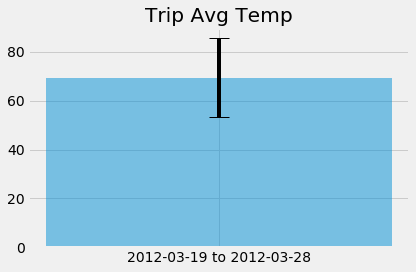

In [140]:
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, avg, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('')
ax.set_xticks(x_pos)
ax.set_xticklabels(vacation_date)
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()


In [148]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.prcp, Measurement.date, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation
]

joined = session.query(*sel, func.sum(Measurement.prcp)).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= '2012-03-19').\
        filter(Measurement.date <= '2012-03-28').\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp)).\
        all()

print (f"The amount of rainfall per weather station for trip dates 2012-03-19 to 2012-03-28 \n")

for record in joined:
    (m_prcp, m_date, s_station, s_name, s_latitude, s_longitude, s_elevation, ms_count) = record
    print(
        f"Prcp: {ms_count}\n{s_station}: {s_name}\nLat: {s_latitude} Long: {s_longitude}\n")

The amount of rainfall per weather station for trip dates 2012-03-19 to 2012-03-28 

Prcp: 0.02
USC00517948: PEARL CITY, HI US
Lat: 21.3934 Long: -157.9751

Prcp: 0.05
USC00511918: HONOLULU OBSERVATORY 702.2, HI US
Lat: 21.3152 Long: -157.9992

Prcp: 0.14
USC00514830: KUALOA RANCH HEADQUARTERS 886.9, HI US
Lat: 21.5213 Long: -157.8374

Prcp: 0.19999999999999998
USC00519397: WAIKIKI 717.2, HI US
Lat: 21.2716 Long: -157.8168

Prcp: 0.29
USC00519523: WAIMANALO EXPERIMENTAL FARM, HI US
Lat: 21.33556 Long: -157.71139

Prcp: 0.68
USC00513117: KANEOHE 838.1, HI US
Lat: 21.4234 Long: -157.8015

Prcp: 1.2200000000000002
USC00519281: WAIHEE 837.5, HI US
Lat: 21.45167 Long: -157.84888999999998

Prcp: 5.51
USC00516128: MANOA LYON ARBO 785.2, HI US
Lat: 21.3331 Long: -157.8025



## Optional Challenge Assignment

In [149]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("12-18")

[(63.0, 71.28, 77.0)]

In [150]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

In [155]:
from datetime import date, timedelta

def daily_normals_vacation(start, end):
    
    """Daily Normals.
    
    Args:
        start (str): A date string in the format '%m-%d'
        end (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    normals = []
    
    start = dt.datetime.strptime(start, '%m-%d-%Y')
    end = dt.datetime.strptime(end, '%m-%d-%Y')
    delta = end - start
    
    for i in range(delta.days + 1):
        day = start + timedelta(days=i)
        
        day2 = dt.datetime.strftime(day, '%m-%d')
        
        sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
        data = session.query(func.strftime("%m-%d", Measurement.date),*sel).filter(func.strftime("%m-%d", Measurement.date) == day2).all()
        
        normals.append(data[0]) 
        
        print(f"{data[0]}")
    
daily_normals_vacation("12-18-2020","12-25-2020")

('12-18', 63.0, 71.28, 77.0)
('12-19', 67.0, 72.0, 78.0)
('12-20', 65.0, 72.91304347826087, 81.0)
('12-21', 67.0, 72.13953488372093, 78.0)
('12-22', 67.0, 71.1304347826087, 77.0)
('12-23', 61.0, 70.34693877551021, 78.0)
('12-24', 62.0, 70.0625, 78.0)
('12-25', 60.0, 71.75, 79.0)


In [157]:
#DIsplays the list
normals

[('12-18', 63.0, 71.28, 77.0),
 ('12-19', 67.0, 72.0, 78.0),
 ('12-20', 65.0, 72.91304347826087, 81.0),
 ('12-21', 67.0, 72.13953488372093, 78.0),
 ('12-22', 67.0, 71.1304347826087, 77.0),
 ('12-23', 61.0, 70.34693877551021, 78.0),
 ('12-24', 62.0, 70.0625, 78.0),
 ('12-25', 60.0, 71.75, 79.0)]

In [158]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_normals = pd.DataFrame(normals, columns =['Date','Min', 'Avg', 'Max']) 
df_normals.set_index('Date')

,Min,Avg,Max
Date,,,
12-18,63.0,71.280000,77.0
12-19,67.0,72.000000,78.0
12-20,65.0,72.913043,81.0
12-21,67.0,72.139535,78.0
12-22,67.0,71.130435,77.0
12-23,61.0,70.346939,78.0
12-24,62.0,70.062500,78.0
12-25,60.0,71.750000,79.0


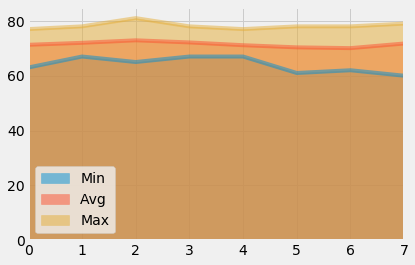

In [159]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df_normals.plot.area(stacked=False)